In [108]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

In [109]:
df = pd.read_csv('/content/cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
df.head()

,date,time,cash_type,coffee_name,money
0,2023-03-01,08:04:19,card,Latte,75
1,2023-03-01,08:08:54,cash,Americano with Milk,70
2,2023-03-01,08:09:03,card,Cappuccino,75
3,2023-03-01,08:10:26,cash,Cappuccino,75
4,2023-03-01,08:15:37,cash,Cappuccino,75


In [110]:
#รวมข้อมูลยอดขายแต่ละเมนู ในแต่ละวัน
daily_sales = df.groupby(['date', 'coffee_name'])['money'].sum().reset_index()
daily_sales.head(10)

,date,coffee_name,money
0,2023-03-01,Americano,1235
1,2023-03-01,Americano with Milk,1890
2,2023-03-01,Cappuccino,1800
3,2023-03-01,Cocoa,350
4,2023-03-01,Cortado,980
5,2023-03-01,Espresso,390
6,2023-03-01,Hot Chocolate,200
7,2023-03-01,Latte,1800
8,2023-03-02,Americano,1235
9,2023-03-02,Americano with Milk,1820


In [111]:
!pip install holidays

In [112]:
def create_sales_features(df):
    # Ensure date is datetime and set as index
    # Check if date is already datetime, if not convert with the correct format
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

    df.set_index('date', inplace=True)

    # Create features from date
    df['dayofweek'] = df.index.dayofweek # 0 = Monday, 6 = Sunday
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['year'] = df.index.year # Add year feature

    # สร้าง holiday feature (ใช้วันหยุดไทย)
    thai_holidays = holidays.Thailand(years=df.index.year.unique())
    df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in thai_holidays else 0)

    # Sort by date before creating lag features
    df.sort_index(inplace=True)

    # Create Lag Features (previous sales)
    # We'll use data from 7 days and 14 days ago to help predict
    df['lag_7'] = df['money'].shift(7)
    df['lag_14'] = df['money'].shift(14)

    # Create Rolling Mean
    df['rolling_mean_7'] = df['money'].shift(1).rolling(window=7).mean()

    # Reset index to make date a column again
    df.reset_index(inplace=True)

    return df


daily_sales_features = create_sales_features(daily_sales.copy())


# Drop rows with NaN values created by lag features
daily_sales_features.dropna(inplace=True)

daily_sales_features.head()

,date,coffee_name,money,dayofweek,quarter,month,dayofyear,year,is_holiday,lag_7,lag_14,rolling_mean_7
14,2023-03-02,Hot Chocolate,350,3,1,3,61,2023,0,1800.0,1235.0,1097.857143
15,2023-03-02,Latte,2325,3,1,3,61,2023,0,1235.0,1890.0,890.714286
16,2023-03-03,Americano,1235,4,1,3,62,2023,0,1820.0,1800.0,1046.428571
17,2023-03-03,Americano with Milk,1890,4,1,3,62,2023,0,1350.0,350.0,962.857143
18,2023-03-03,Cappuccino,1200,4,1,3,62,2023,0,400.0,980.0,1040.000000


In [113]:
# Convert 'date' column to datetime objects
# Ensure 'date' is a column first if it was set as index
if df.index.name == 'date':
    df.reset_index(inplace=True)

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

# Display the data types to confirm the conversion
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68359 entries, 0 to 68358
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         68359 non-null  datetime64[ns]
 1   time         68359 non-null  object        
 2   cash_type    68359 non-null  object        
 3   coffee_name  68359 non-null  object        
 4   money        68359 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.6+ MB


None

In [114]:
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'lag_7', 'lag_14', 'rolling_mean_7', 'is_holiday']
TARGET = 'money'

In [115]:
X = daily_sales_features[FEATURES]
y = daily_sales_features[TARGET]

In [116]:
# # Ensure the 'date' column is datetime
# daily_sales_features['date'] = pd.to_datetime(daily_sales_features['date'])

# # กำหนด split_date = วันที่สูงสุด - 2 เดือน
# split_date = daily_sales_features['date'].max() - pd.DateOffset(months=2)

# print("Split date:", split_date.strftime("%Y-%m-%d"))

# # แบ่ง train/test ตามเวลา
# train_data = daily_sales_features[daily_sales_features['date'] <= split_date]
# test_data  = daily_sales_features[daily_sales_features['date'] > split_date]

# # กำหนด X (features) และ y (target)
# X_train = train_data[FEATURES]
# y_train = train_data[TARGET]
# X_test  = test_data[FEATURES]
# y_test  = test_data[TARGET]

# print(f"Shape of X_train: {X_train.shape}")
# print(f"Shape of y_train: {y_train.shape}")
# print(f"Shape of X_test: {X_test.shape}")
# print(f"Shape of y_test: {y_test.shape}")



=== Coffee: Americano ===
Random Forest MAE: 296.84
XGBoost MAE      : 271.66
Test Data Points : 61 วัน


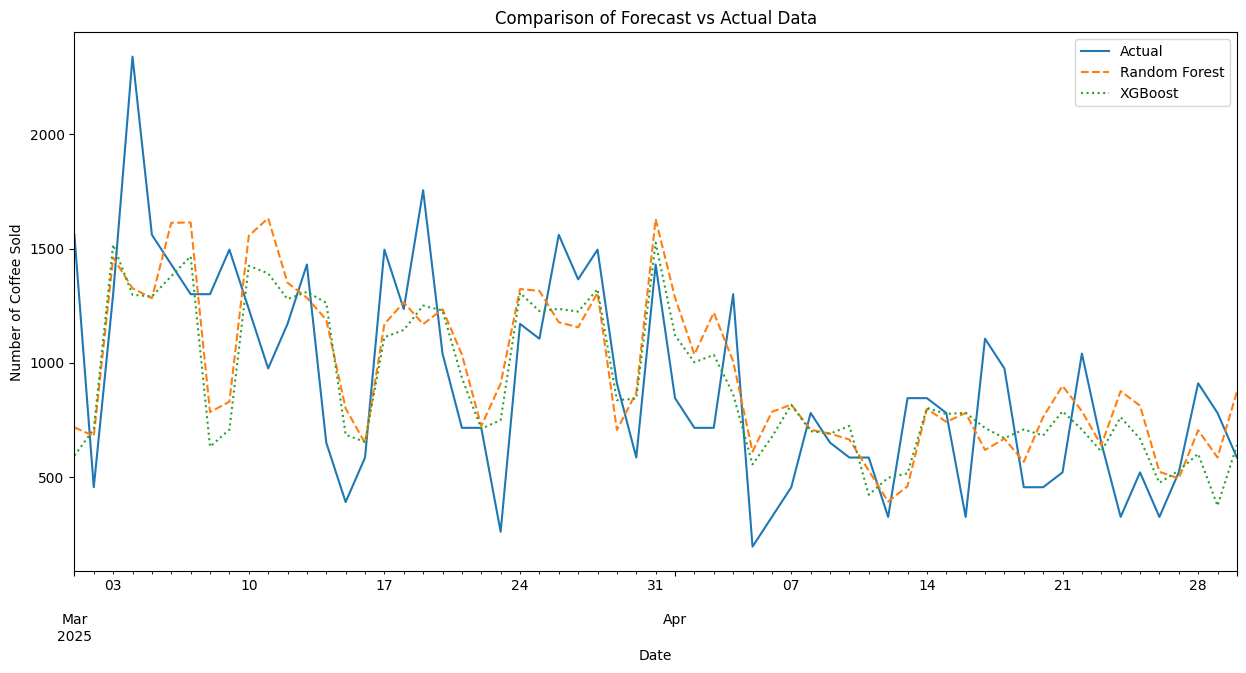


=== Coffee: Americano with Milk ===
Random Forest MAE: 392.86
XGBoost MAE      : 369.94
Test Data Points : 61 วัน


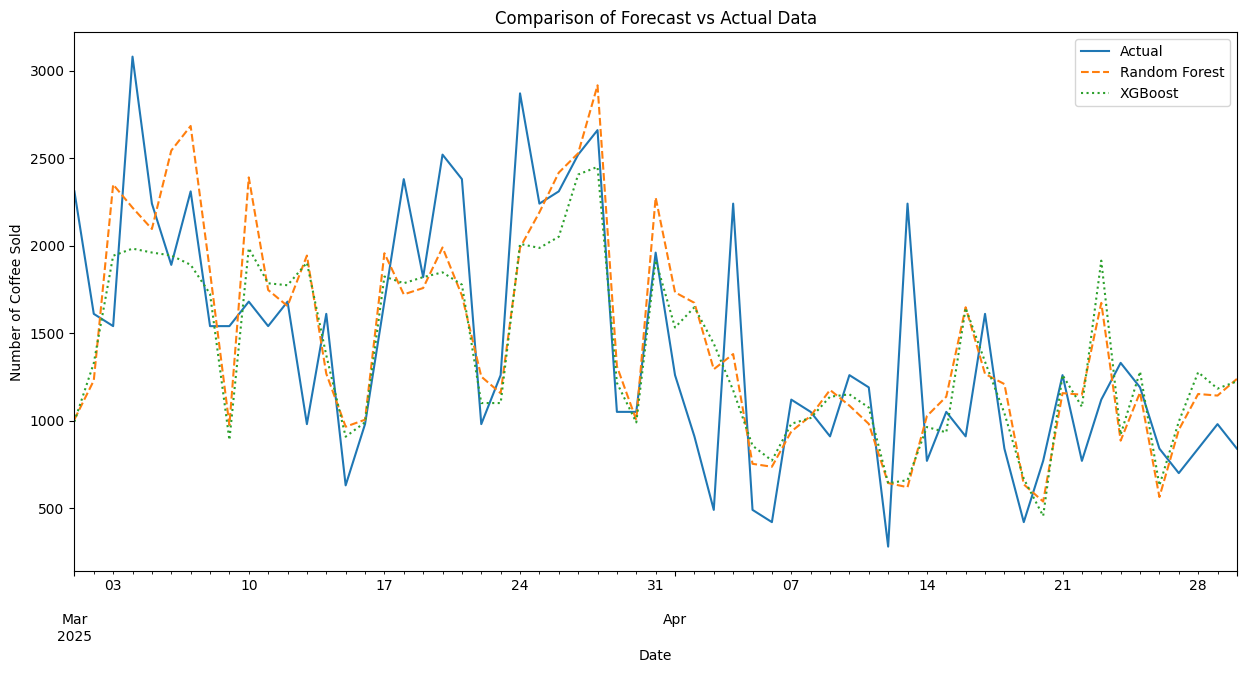


=== Coffee: Cappuccino ===
Random Forest MAE: 296.15
XGBoost MAE      : 294.08
Test Data Points : 61 วัน


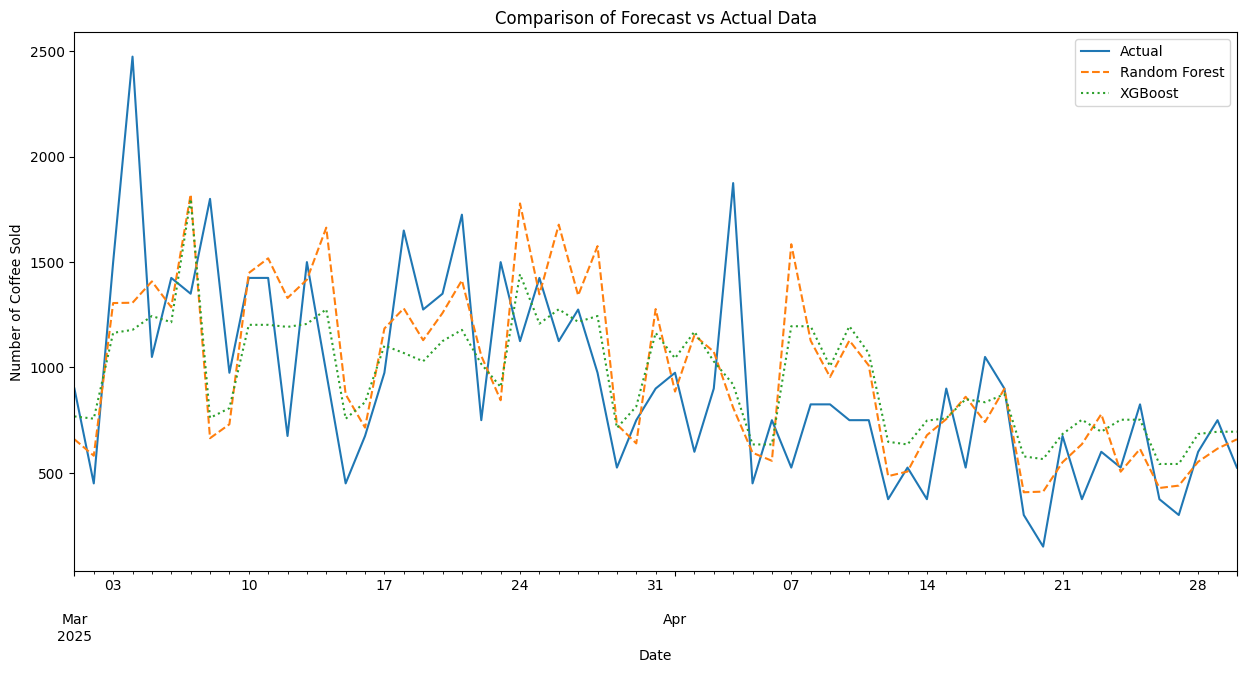


=== Coffee: Cocoa ===
Random Forest MAE: 114.84
XGBoost MAE      : 118.80
Test Data Points : 60 วัน


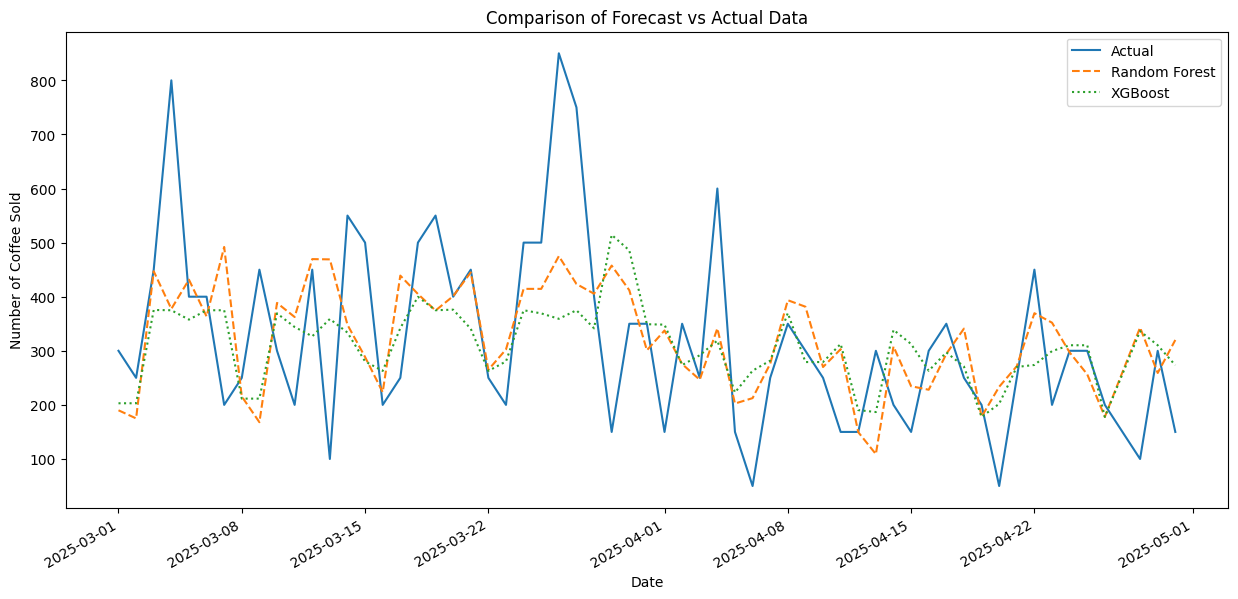


=== Coffee: Cortado ===
Random Forest MAE: 200.06
XGBoost MAE      : 207.16
Test Data Points : 61 วัน


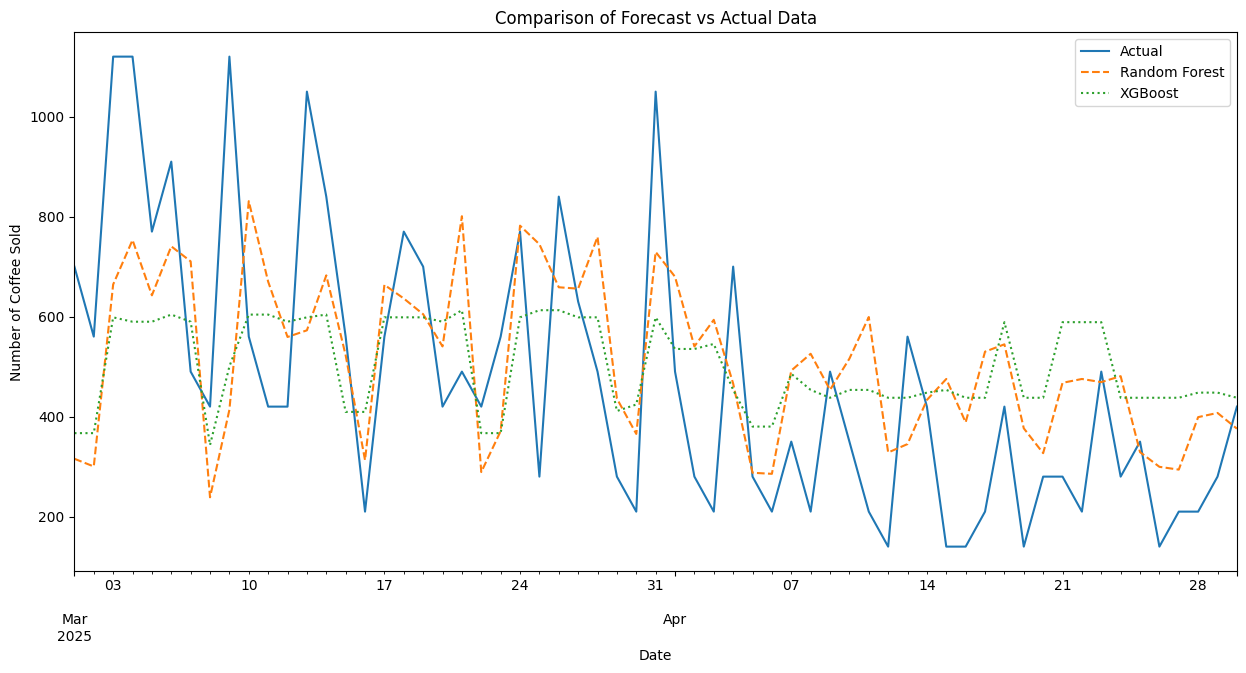


=== Coffee: Espresso ===
Random Forest MAE: 100.37
XGBoost MAE      : 93.86
Test Data Points : 56 วัน


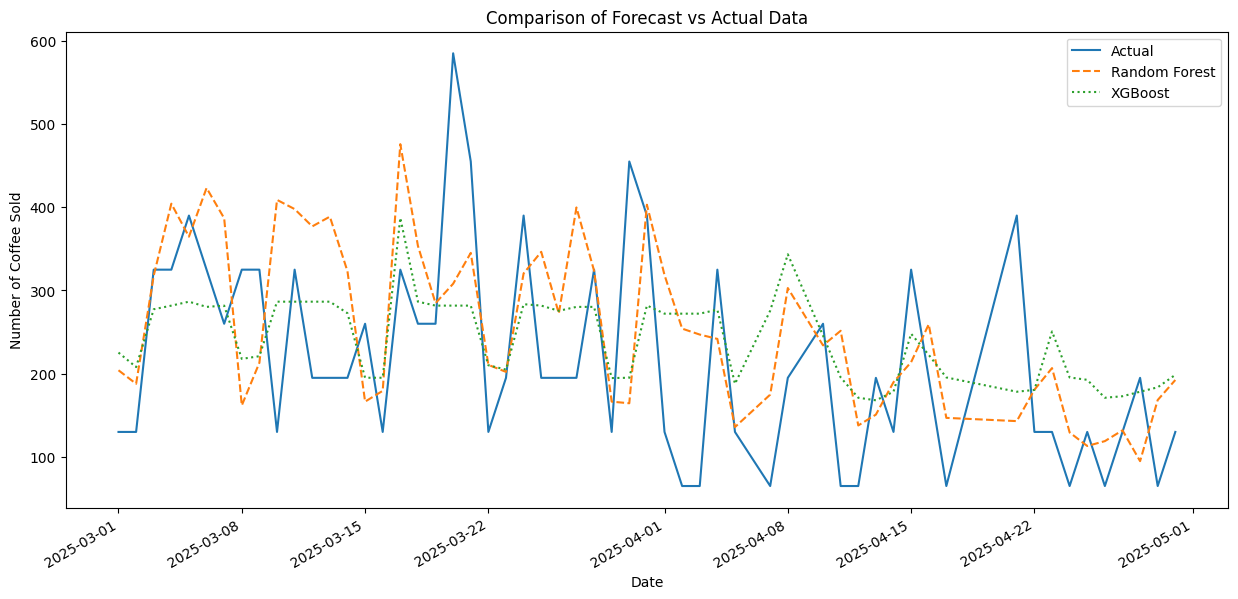


=== Coffee: Hot Chocolate ===
Random Forest MAE: 143.55
XGBoost MAE      : 132.56
Test Data Points : 61 วัน


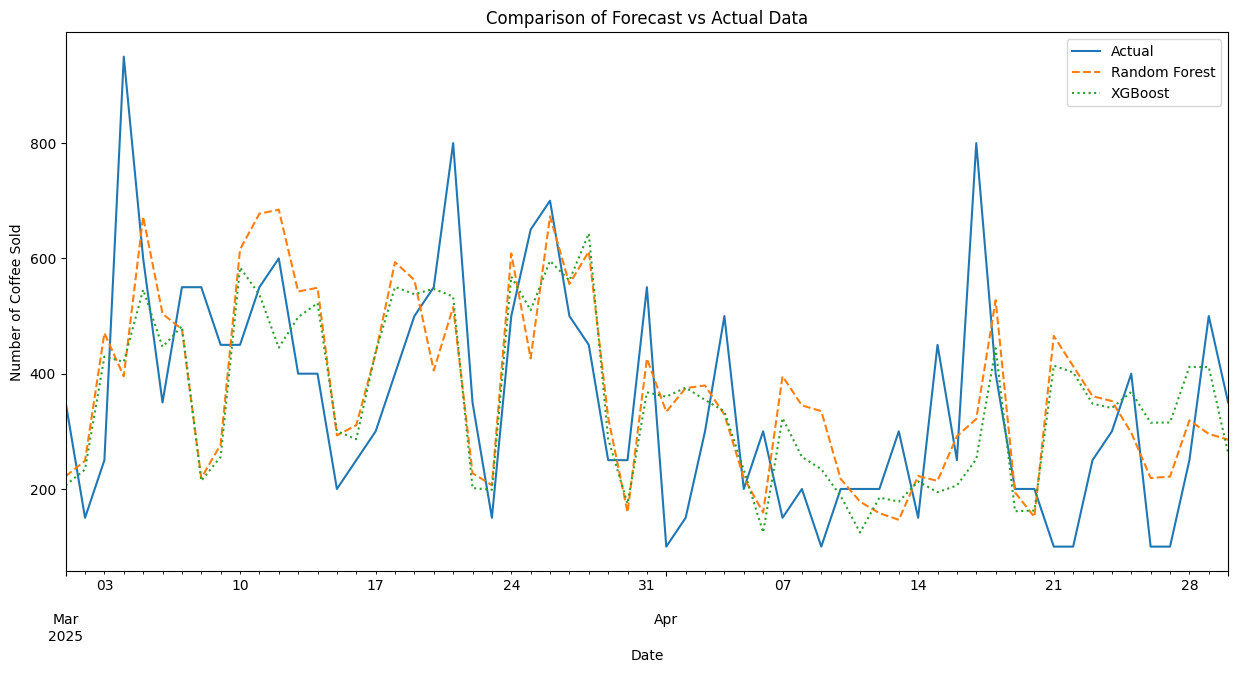


=== Coffee: Latte ===
Random Forest MAE: 366.25
XGBoost MAE      : 374.02
Test Data Points : 61 วัน


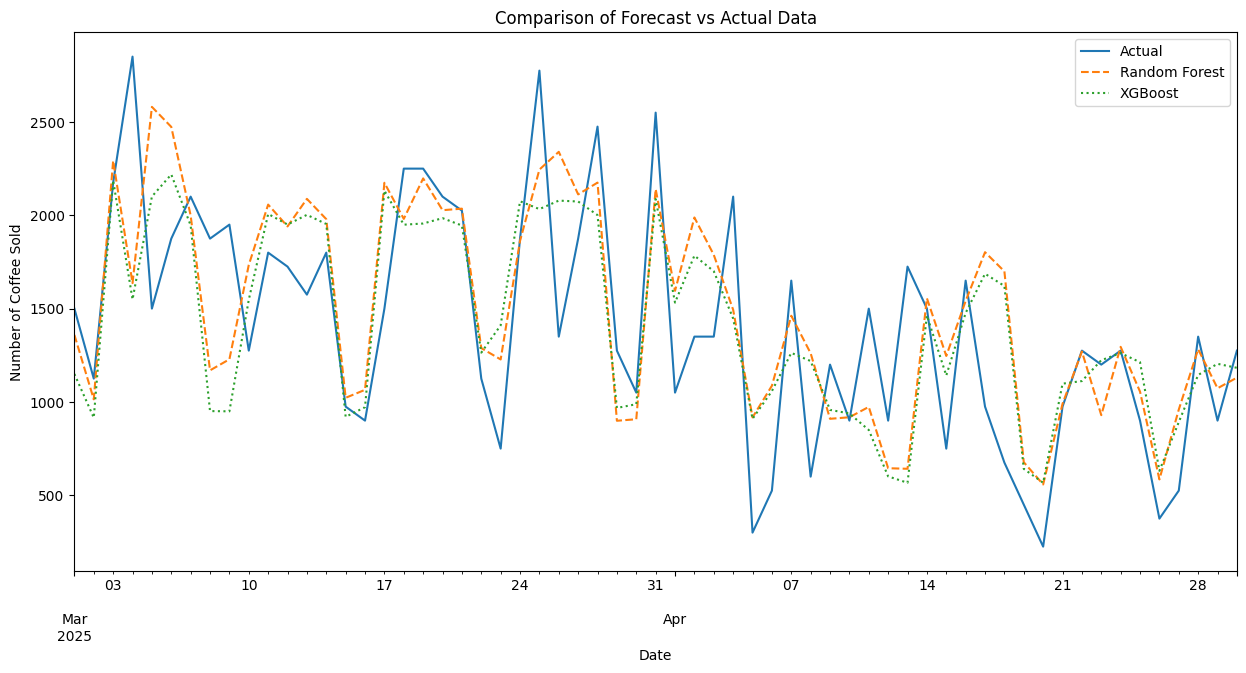

In [117]:
#แยกตาม menu
coffee_names = daily_sales['coffee_name'].unique()

for coffee in coffee_names:
    daily_sales_features['date'] = pd.to_datetime(daily_sales_features['date'])
    print(f"\n=== Coffee: {coffee} ===")

    coffee_data = daily_sales[daily_sales['coffee_name'] == coffee].copy()

    coffee_features = create_sales_features(coffee_data)
    coffee_features.dropna(inplace=True)  # ลบ NaN ที่มาจาก lag

    # train/test split → 2 เดือนสุดท้ายเป็น test
    split_date = coffee_features['date'].max() - pd.DateOffset(months=2)
    train_data = coffee_features[coffee_features['date'] <= split_date]
    test_data  = coffee_features[coffee_features['date'] > split_date]

    X_train, y_train = train_data[FEATURES], train_data[TARGET]
    X_test,  y_test  = test_data[FEATURES], test_data[TARGET]

    # ----- Random Forest -----
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_mae  = mean_absolute_error(y_test, rf_pred)

    # ----- XGBoost -----
    xgb_model = xgb.XGBRegressor(n_estimators=100,
                                 learning_rate=0.05,
                                 early_stopping_rounds=10,
                                 random_state=42)
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    xgb_pred = xgb_model.predict(X_test)
    xgb_mae  = mean_absolute_error(y_test, xgb_pred)

    print(f"Random Forest MAE: {rf_mae:.2f}")
    print(f"XGBoost MAE      : {xgb_mae:.2f}")
    print(f"Test Data Points : {len(y_test)} วัน")
    results = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
    })

    # Set the index of the results DataFrame to the dates from the test set
    results.index = test_data['date']

    results.plot(figsize=(15, 7), style=['-', '--', ':'],
    title='Comparison of Forecast vs Actual Data')
    plt.ylabel('Number of Coffee Sold')
    plt.xlabel('Date')
    plt.legend()
    plt.show()

In [118]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [119]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate=0.05, # ค่อยๆ เรียนรู้ช้าๆ
                             early_stopping_rounds=10, # ถ้าผลไม่ดีขึ้น 10 รอบให้หยุด
                             random_state=42)

In [120]:
# XGBoost ต้องมี evaluation set เพื่อใช้ early stopping
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [121]:
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

In [122]:
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

In [123]:
print(f"\nความคลาดเคลื่อนเฉลี่ยของ Random Forest: {rf_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ความคลาดเคลื่อนเฉลี่ยของ XGBoost: {xgb_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ยอดขายรวมใน Test Set: {y_test.sum():.2f} บาท")


ความคลาดเคลื่อนเฉลี่ยของ Random Forest: 366.25 จากทั้งหมด 61 จุดข้อมูล
ความคลาดเคลื่อนเฉลี่ยของ XGBoost: 374.02 จากทั้งหมด 61 จุดข้อมูล
ยอดขายรวมใน Test Set: 85650.00 บาท


In [124]:
results = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
})

# Set the index of the results DataFrame to the dates from the test set
results.index = test_data['date']

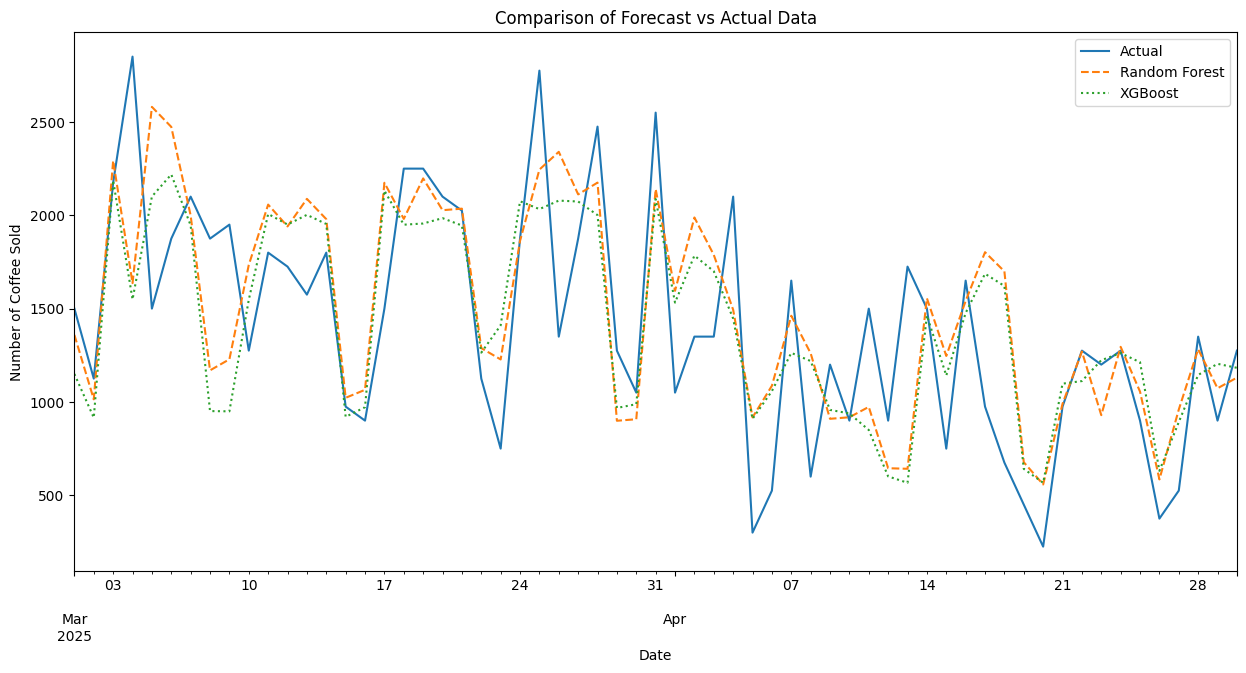

In [125]:
results.plot(figsize=(15, 7), style=['-', '--', ':'],
             title='Comparison of Forecast vs Actual Data')
plt.ylabel('Number of Coffee Sold')
plt.xlabel('Date')
plt.legend()
plt.show()

In [126]:
!pip install prophet

In [127]:
from prophet import Prophet

In [128]:
# Prepare data for Prophet: requires 'ds' (datetime) and 'y' (target) columns
# Use the already split train_data and test_data DataFrames

# Add print statements to check columns
print("Columns in train_data:", train_data.columns)
print("Columns in test_data:", test_data.columns)

Columns in train_data: Index(['date', 'coffee_name', 'money', 'dayofweek', 'quarter', 'month',
       'dayofyear', 'year', 'is_holiday', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')
Columns in test_data: Index(['date', 'coffee_name', 'money', 'dayofweek', 'quarter', 'month',
       'dayofyear', 'year', 'is_holiday', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')



=== Coffee: Americano ===


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3u50tql/motomakn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3u50tql/_f4rqjij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83090', 'data', 'file=/tmp/tmpl3u50tql/motomakn.json', 'init=/tmp/tmpl3u50tql/_f4rqjij.json', 'output', 'file=/tmp/tmpl3u50tql/prophet_modelxl0cw6r1/prophet_model-20250921160149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:01:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:01:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE      : 301.84
Test Data Points : 61 วัน


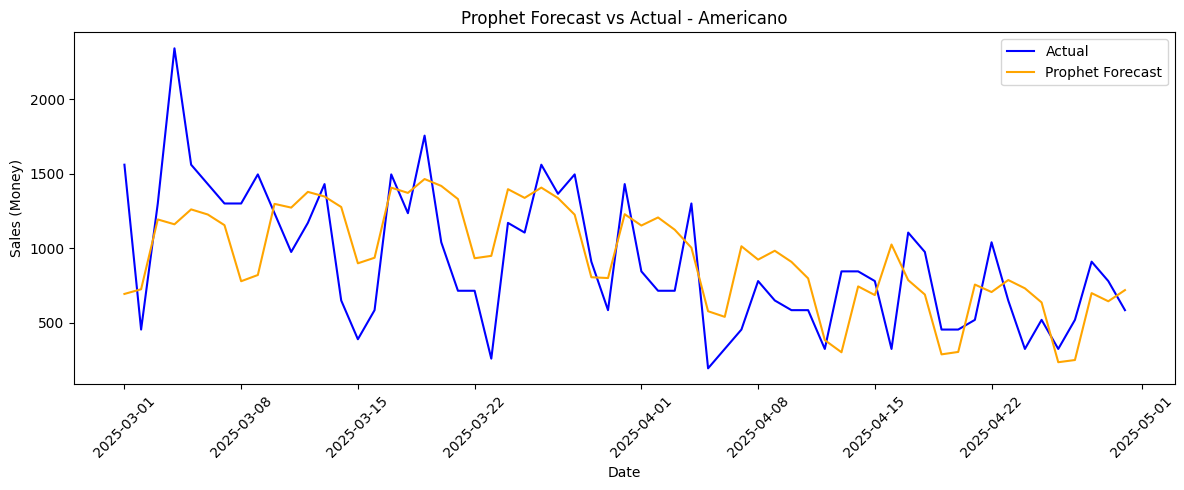

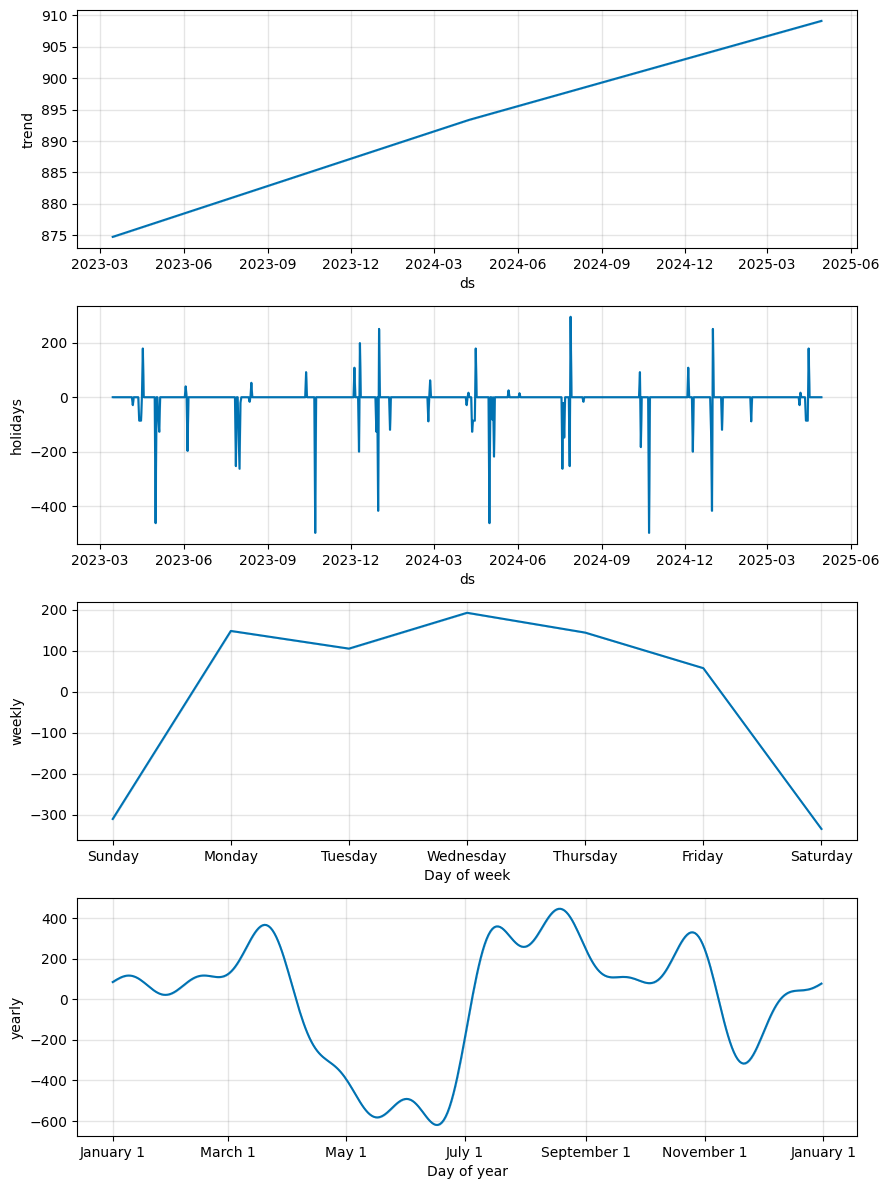

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



=== Coffee: Americano with Milk ===


DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3u50tql/8wwsad7n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3u50tql/ct7lwqho.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86860', 'data', 'file=/tmp/tmpl3u50tql/8wwsad7n.json', 'init=/tmp/tmpl3u50tql/ct7lwqho.json', 'output', 'file=/tmp/tmpl3u50tql/prophet_modeleoiubnha/prophet_model-20250921160150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:01:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:01:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE      : 405.43
Test Data Points : 61 วัน


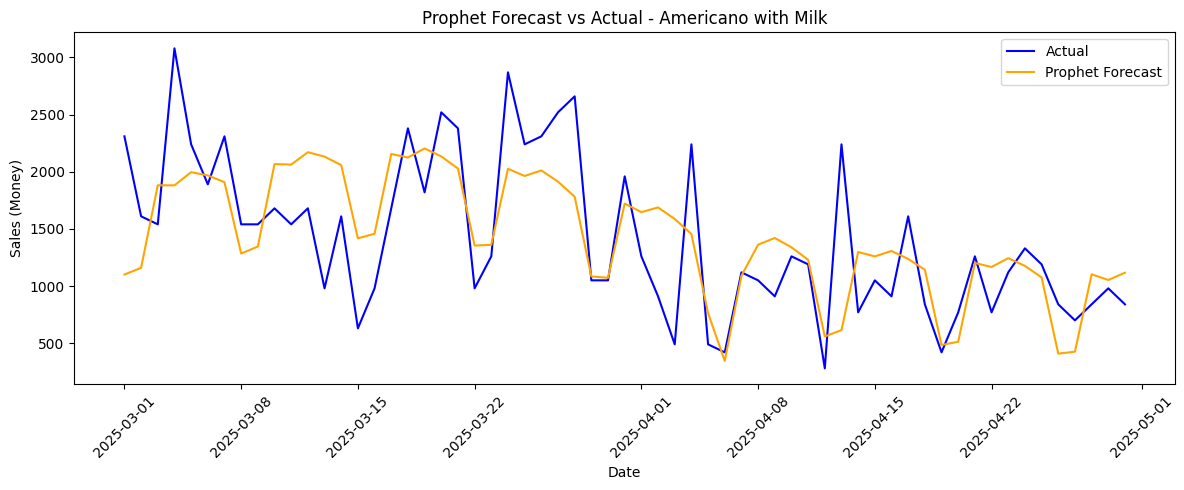

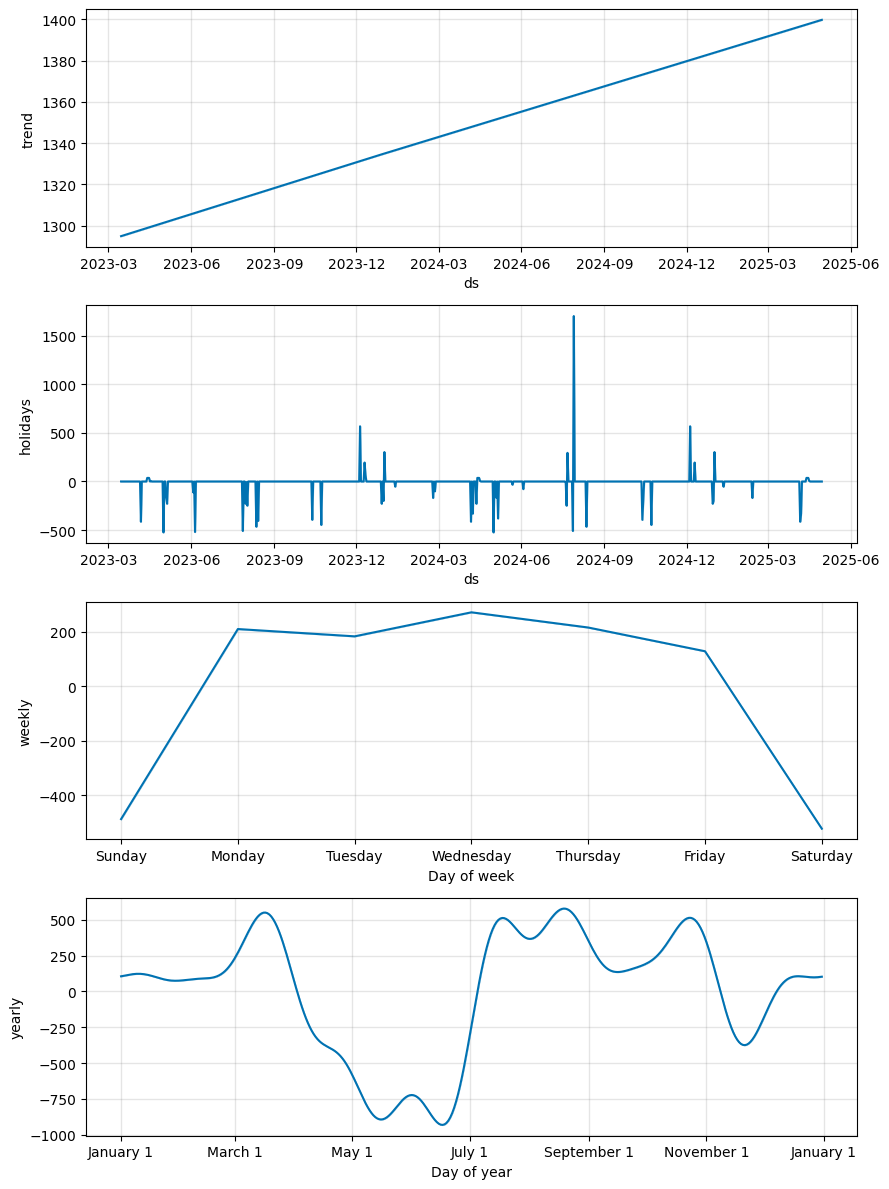

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



=== Coffee: Cappuccino ===


DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3u50tql/htfuvhl4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3u50tql/xkvqa7ij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98634', 'data', 'file=/tmp/tmpl3u50tql/htfuvhl4.json', 'init=/tmp/tmpl3u50tql/xkvqa7ij.json', 'output', 'file=/tmp/tmpl3u50tql/prophet_modelw1vn81a1/prophet_model-20250921160153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:01:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:01:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE      : 235.92
Test Data Points : 61 วัน


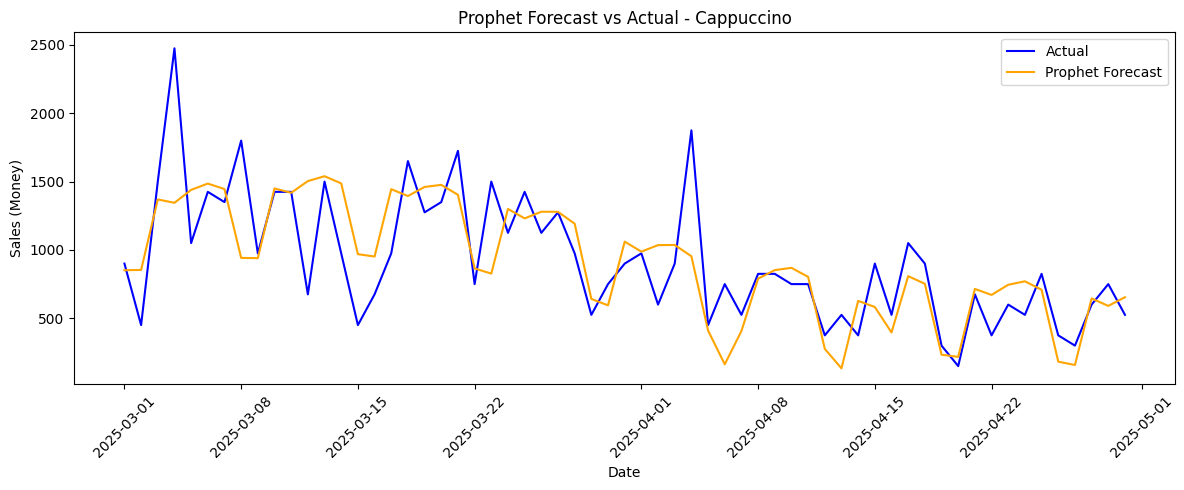

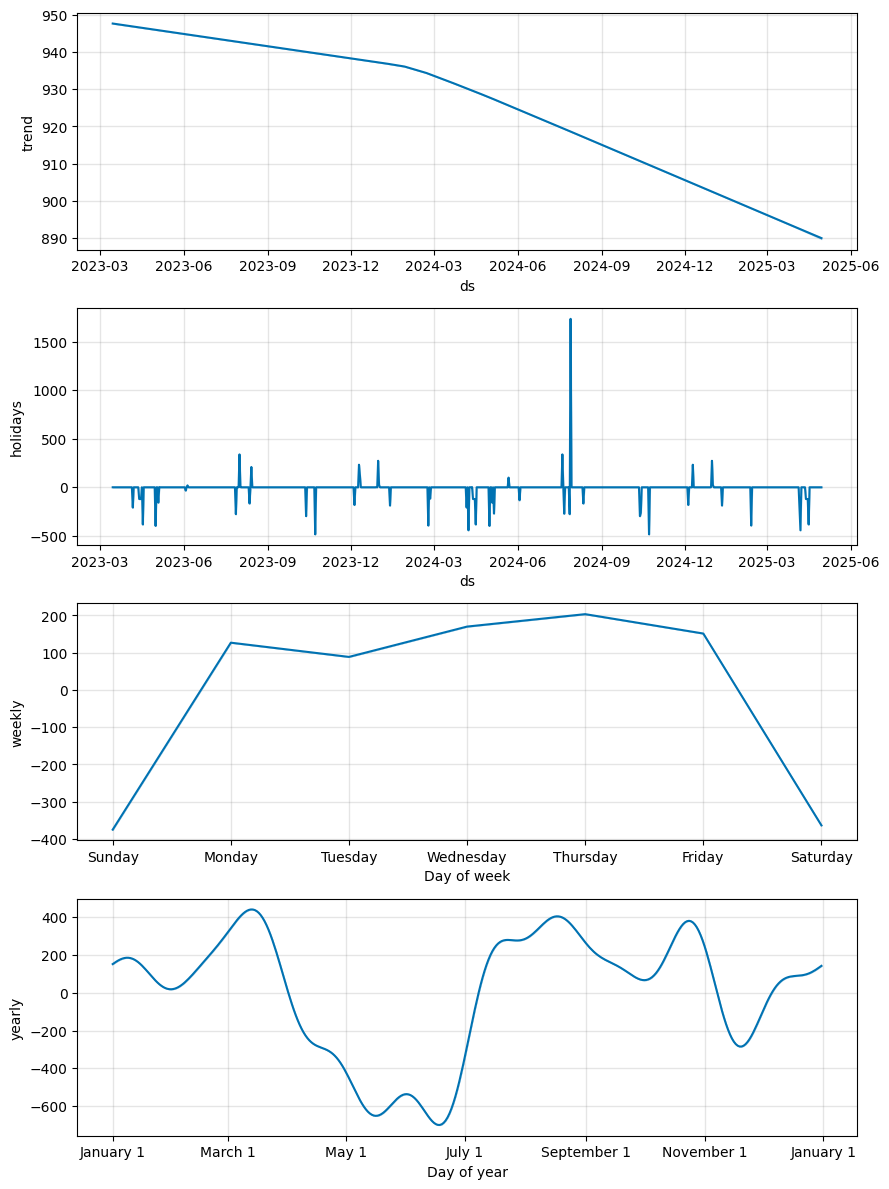


=== Coffee: Cocoa ===


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3u50tql/mqsnwmwu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3u50tql/kp7x3glj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35665', 'data', 'file=/tmp/tmpl3u50tql/mqsnwmwu.json', 'init=/tmp/tmpl3u50tql/kp7x3glj.json', 'output', 'file=/tmp/tmpl3u50tql/prophet_model8usep812/prophet_model-20250921160155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:01:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:01:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE      : 106.99
Test Data Points : 61 วัน


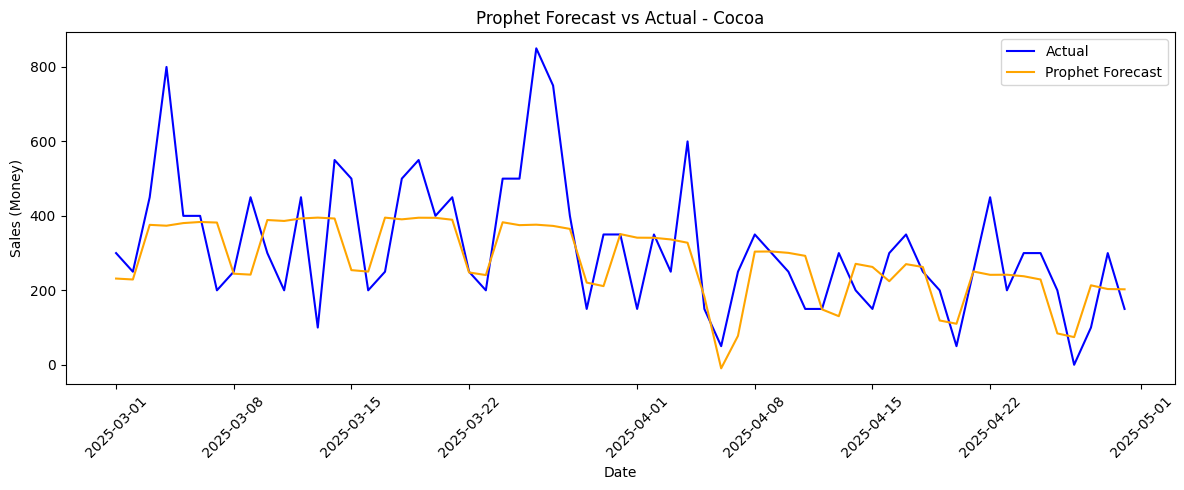

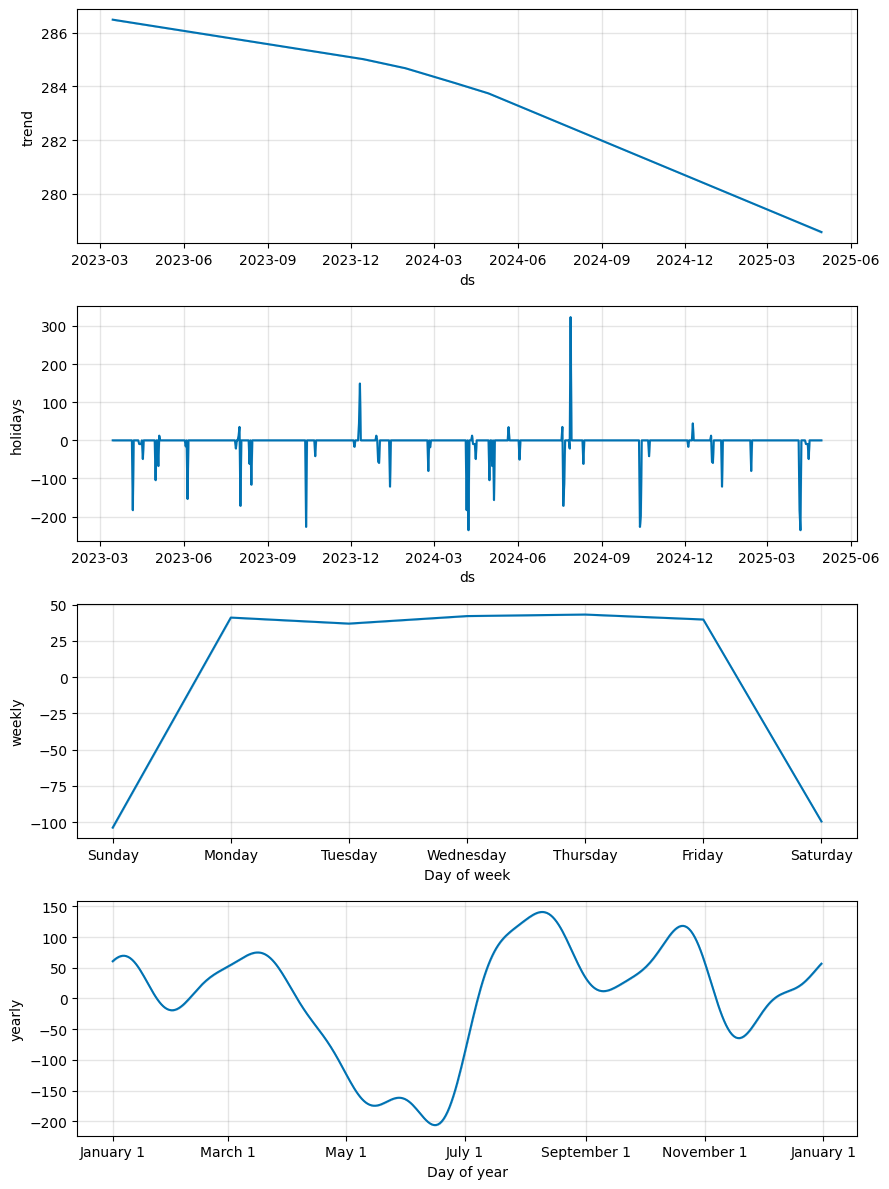

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



=== Coffee: Cortado ===


DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3u50tql/csxsriot.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3u50tql/12chqi8e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46037', 'data', 'file=/tmp/tmpl3u50tql/csxsriot.json', 'init=/tmp/tmpl3u50tql/12chqi8e.json', 'output', 'file=/tmp/tmpl3u50tql/prophet_modeleoazucqr/prophet_model-20250921160158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:01:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:01:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE      : 177.30
Test Data Points : 61 วัน


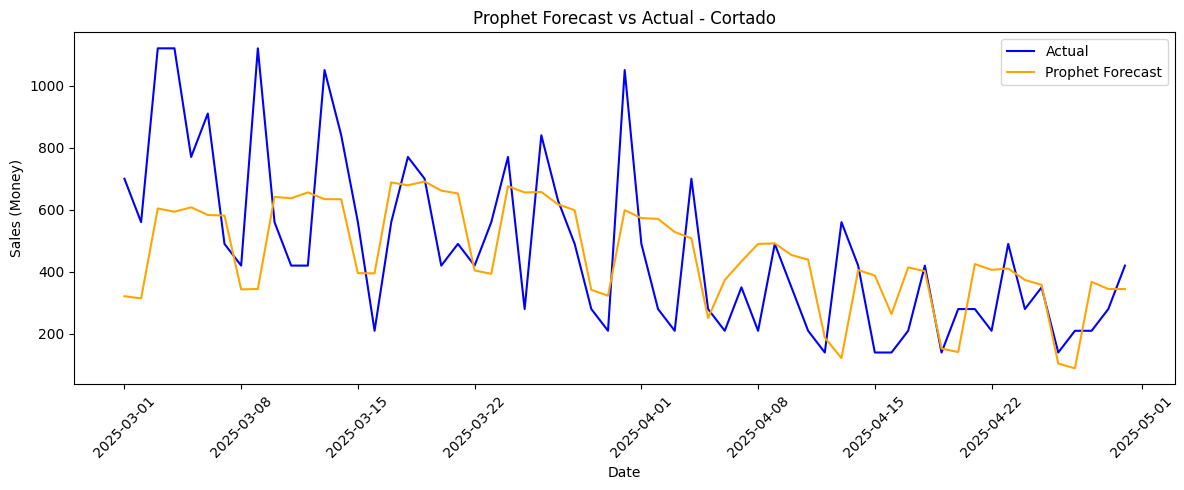

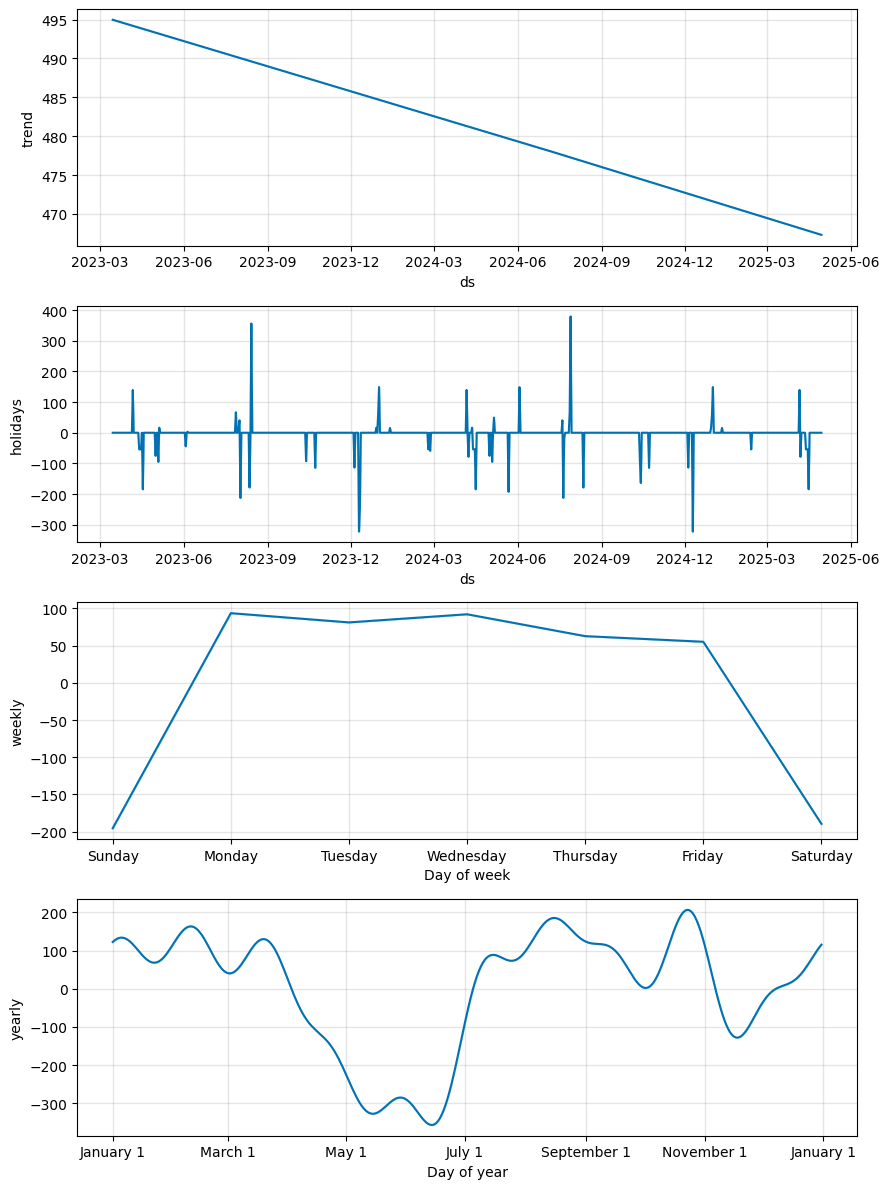


=== Coffee: Espresso ===


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3u50tql/hwcfzfmi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3u50tql/s3jcwtli.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33376', 'data', 'file=/tmp/tmpl3u50tql/hwcfzfmi.json', 'init=/tmp/tmpl3u50tql/s3jcwtli.json', 'output', 'file=/tmp/tmpl3u50tql/prophet_modelg1m0g1ds/prophet_model-20250921160202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:02:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:02:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE      : 90.36
Test Data Points : 61 วัน


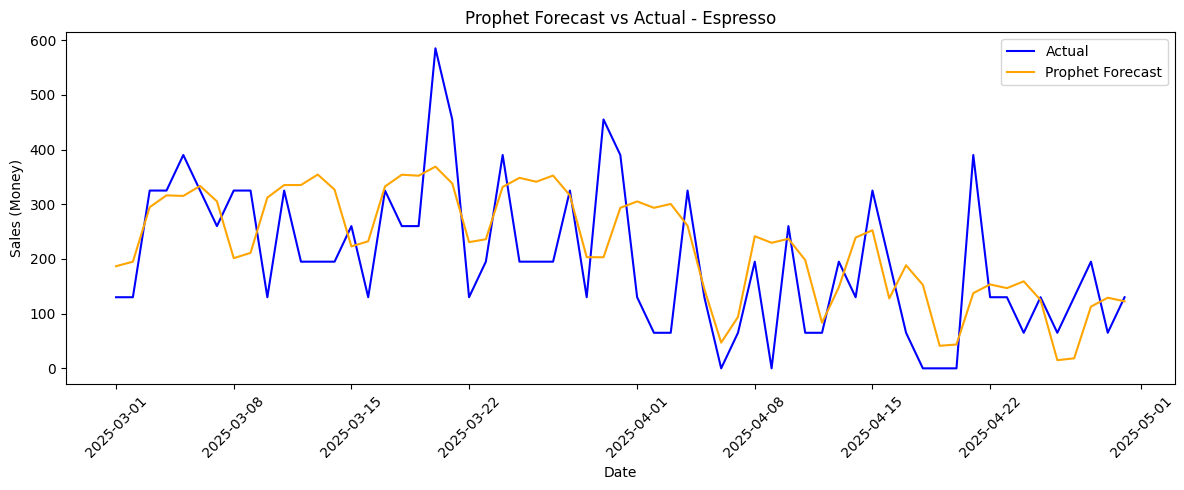

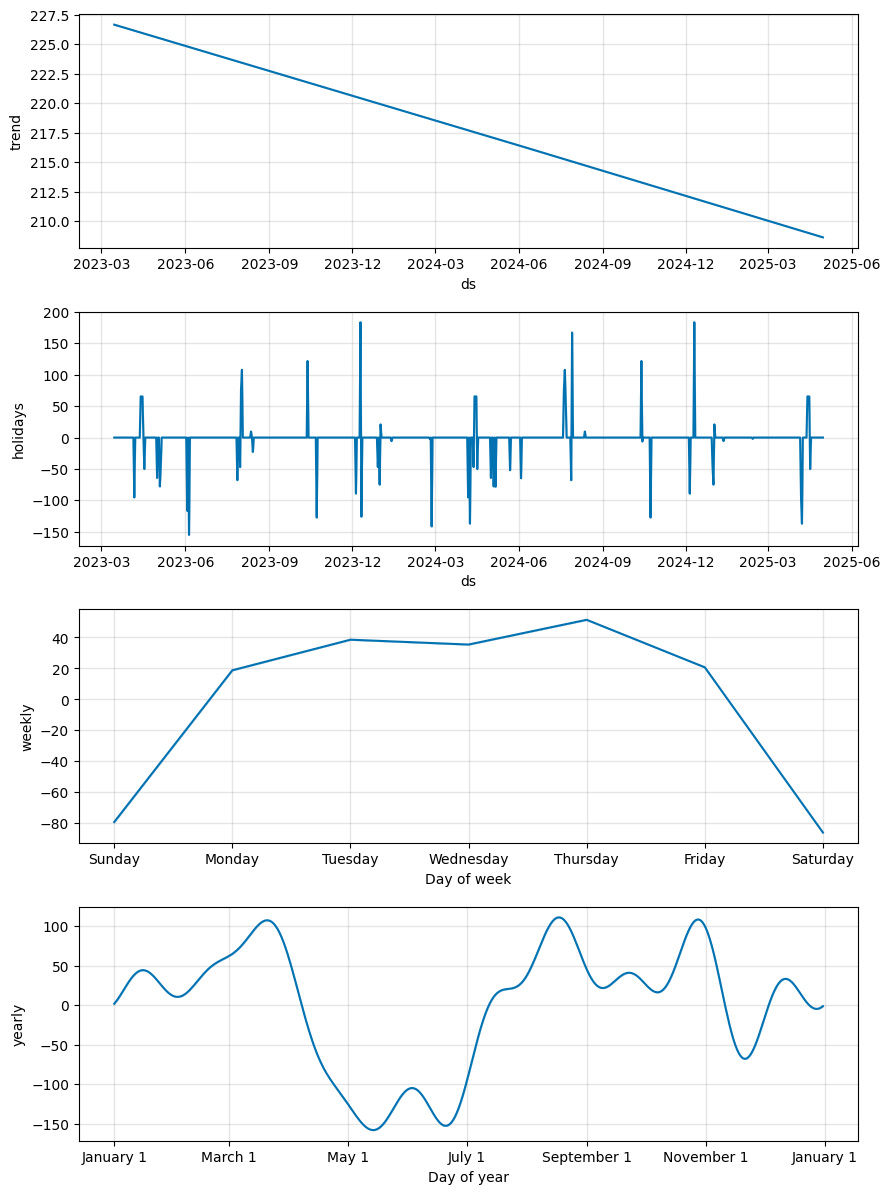

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3u50tql/nv_hf2_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3u50tql/ydtikoyj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51683', 'data', 'file=/tmp/tmpl3u50tql/nv_hf2_9.json', 'init=/tmp/tmpl3u50tql/ydtikoyj.json', 'output', 'file=/tmp/tmpl3u50tql/prophet_modelqhpj452r/prophet_model-20250921160204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:02:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



=== Coffee: Hot Chocolate ===


16:02:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE      : 134.09
Test Data Points : 61 วัน


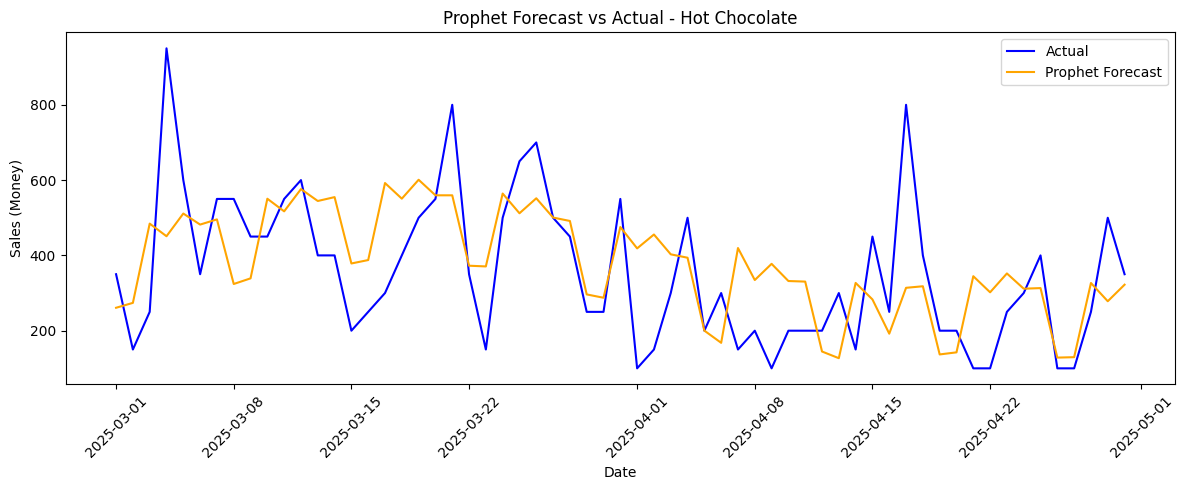

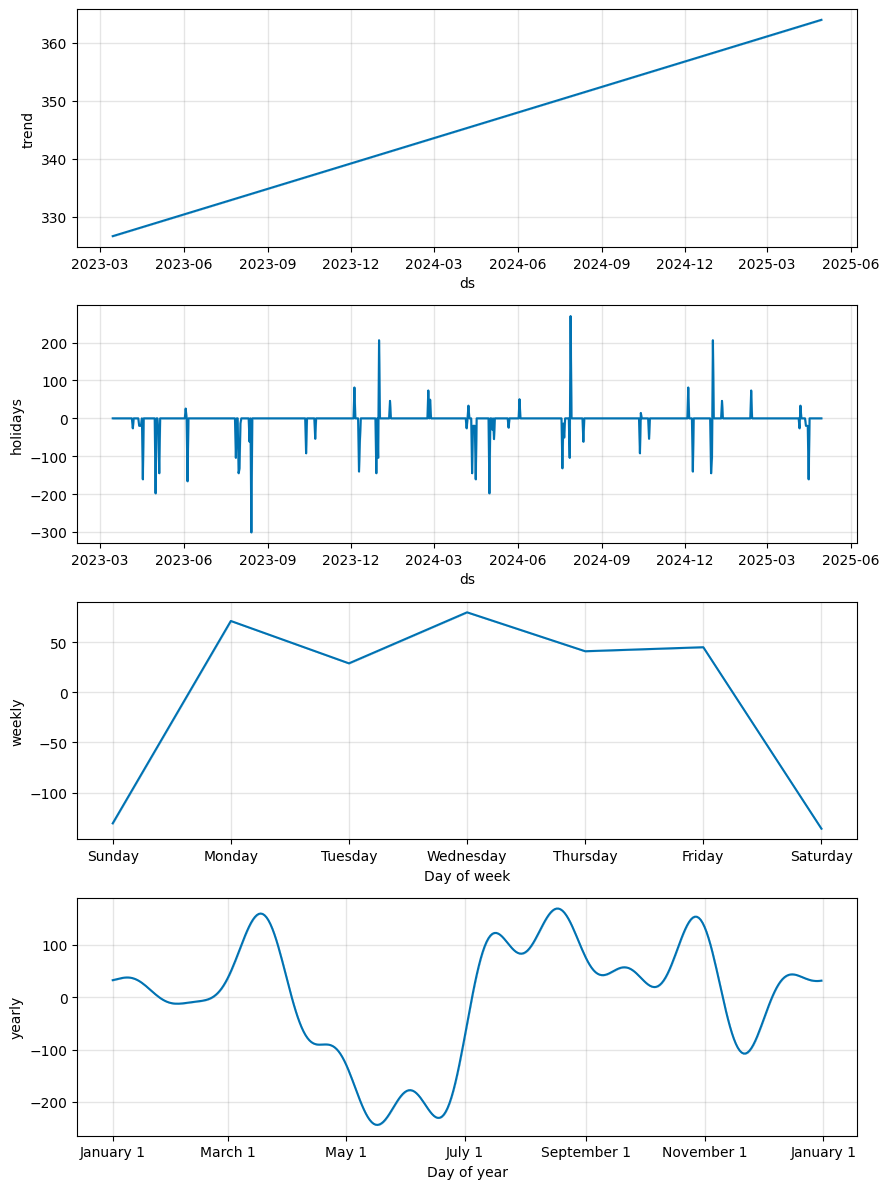

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3u50tql/zt6wrt8d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3u50tql/1simv459.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9958', 'data', 'file=/tmp/tmpl3u50tql/zt6wrt8d.json', 'init=/tmp/tmpl3u50tql/1simv459.json', 'output', 'file=/tmp/tmpl3u50tql/prophet_modelc6f0fri1/prophet_model-20250921160205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:02:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



=== Coffee: Latte ===


16:02:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE      : 377.20
Test Data Points : 61 วัน


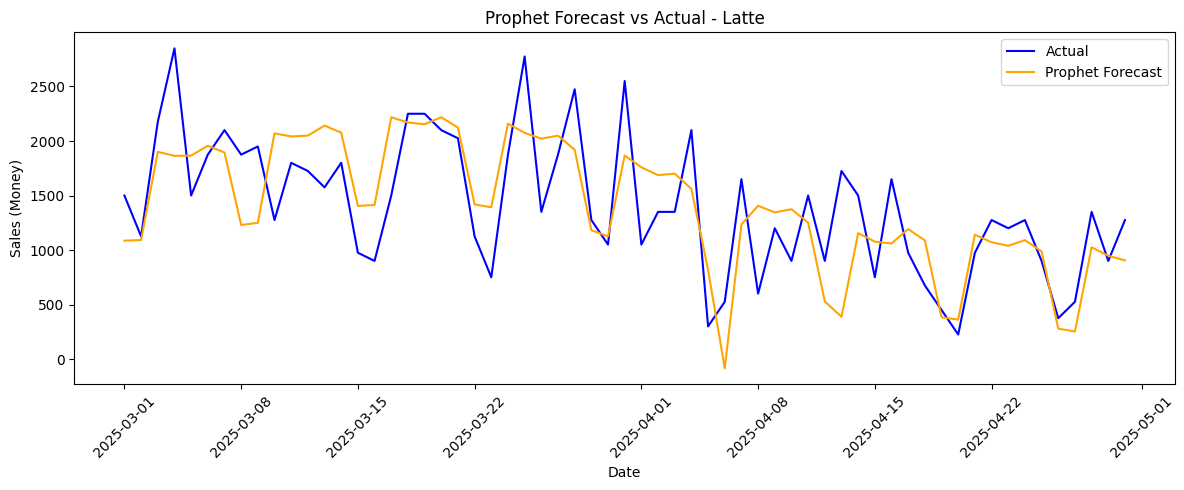

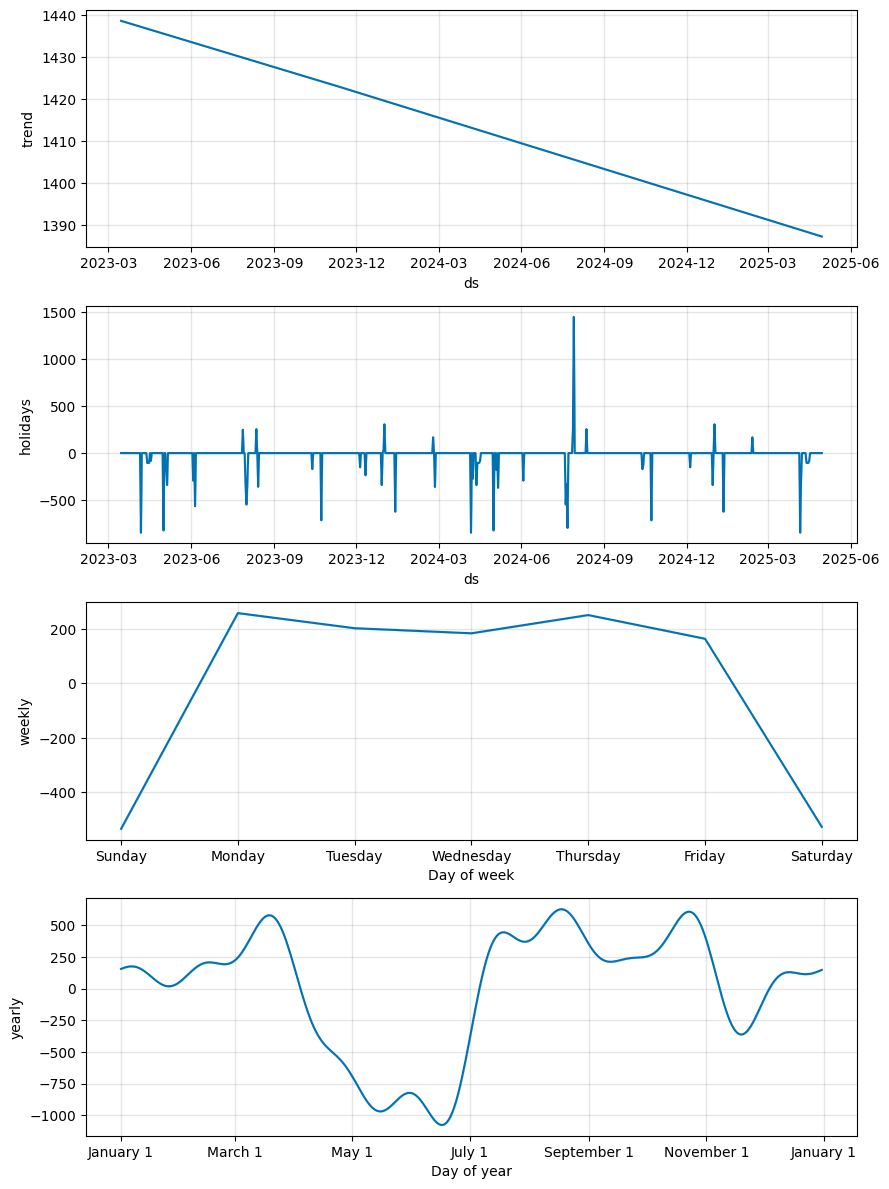

In [129]:
for coffee in coffee_names:
    print(f"\n=== Coffee: {coffee} ===")

    coffee_data = daily_sales[daily_sales['coffee_name'] == coffee].copy()
    coffee_data = coffee_data.set_index('date').asfreq('D').fillna({'money': 0, 'coffee_name': coffee}).reset_index()
    coffee_features = create_sales_features(coffee_data)
    coffee_features.dropna(inplace=True)

    # train/test split → 2 เดือนสุดท้ายเป็น test
    split_date = coffee_features['date'].max() - pd.DateOffset(months=2)
    train_data = coffee_features[coffee_features['date'] <= split_date]
    test_data  = coffee_features[coffee_features['date'] > split_date]

    # ---------- Prophet ----------
    prophet_train = train_data[['date', 'money']].rename(columns={'date':'ds', 'money':'y'})
    prophet_test  = test_data[['date', 'money']].rename(columns={'date':'ds', 'money':'y'})

    # fit model
    model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    model.add_country_holidays(country_name='TH')  # เพิ่มวันหยุดไทย
    model.fit(prophet_train)

    # สร้าง future df ที่ครอบคลุม test period
    future = model.make_future_dataframe(periods=len(prophet_test), freq='D')
    forecast = model.predict(future)

    # join forecast กับ test
    prophet_results = forecast.set_index('ds')[['yhat']].join(prophet_test.set_index('ds')[['y']])
    prophet_results.dropna(inplace=True)

    # คำนวณ MAE
    prophet_mae = mean_absolute_error(prophet_results['y'], prophet_results['yhat'])

    print(f"Prophet MAE      : {prophet_mae:.2f}")
    print(f"Test Data Points : {len(prophet_results)} วัน")

    # กราฟเปรียบเทียบ
    plt.figure(figsize=(12,5))
    plt.plot(prophet_results.index, prophet_results['y'], label="Actual", color="blue")
    plt.plot(prophet_results.index, prophet_results['yhat'], label="Prophet Forecast", color="orange")
    plt.title(f"Prophet Forecast vs Actual - {coffee}")
    plt.xlabel("Date")
    plt.ylabel("Sales (Money)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # แสดง components (trend/seasonality/holiday)
    model.plot_components(forecast)
    plt.show()